In [1]:
%matplotlib inline

import sys
import os
import pathlib
import logging

import numpy
import matplotlib
from matplotlib import pyplot

# Need to add the lib_elasticc2 directory to the PYTHONPATH so that we
#  can import it
libdir = pathlib.Path( os.getcwd() ).parent.parent / "lib_elasticc2"
sys.path.insert( 0, str(libdir) )
from read_snana import elasticc2_snana_reader

# Make a logger so that we can print out timings and things like that
_logger = logging.getLogger("main")
if not _logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    _logger.addHandler( _logout )
    _logout.setFormatter( logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s',
                                             datefmt='%Y-%m-%d %H:%M:%S' ) )
_logger.setLevel( logging.INFO )
_logger.info( "Testing" )

# Make a random number generator.  If you 
#  want reproducibility, set the seed
#  to something other than None.
# _random_seed = None
_random_seed = 42
rng = numpy.random.default_rng( seed=_random_seed )


[2024-10-23 11:01:31 - INFO] - Testing


In [2]:
# Create a reader for further use
# It needs to know where to find the ELAsTiCC2 SNANA FITS files
# If on NERSC, it will default to the right place, and you don't need
#   to put anything here.
# If you have set the TD environment variable, it will look in
#   the ELASTICC2 subdirectory of $TD
# Otherewise, explicitly give the path to the constructor
esr = elasticc2_snana_reader( "/data/raknop/ELASTICC2" )

In [22]:
# Define a function for plotting lightcurves.  We're going to use
# this lots below, and this saves repeated code in cells
def plot_ltcv( ltcv, figsize=(6,6), multiplots=False ):
    plotcolors = { 'u': '#cc0ccc', 'g': '#00cc88', 'r': '#cc0000', 'i': '#cc8800', 'z': '#888800' }
    if multiplots:
        fig, axes = pyplot.subplots( 3, 2, figsize=figsize, tight_layout=True )
        axes = axes.flatten()
    else:
        fig, axes = pyplot.subplots( 1, 1, figsize=figsize, tight_layout=True )
        axes = [ axes ]
    axesdex = 0
    xmin = 1e32
    xmax = -1e32
    for band in [ 'u', 'g', 'r', 'i', 'z' ]:
        bandltcv = ltcv[ ltcv['BAND'] == band ]
        if len( bandltcv ) > 0:
            axes[axesdex].errorbar( bandltcv['MJD'], bandltcv['FLUXCAL'], yerr=bandltcv['FLUXCALERR'],
                                    color=plotcolors[band], linestyle='None', marker='o',
                                    label=band )
            thisxmin, thisxmax = axes[axesdex].get_xlim()
            xmin = min( thisxmin, xmin )
            xmax = max( thisxmax, xmax )
        if multiplots: axesdex += 1

    for axis in axes:
        axis.set_xlim( xmin, xmax )
        axis.set_title( f"SN {snid} at z={snia_truth[ snia_truth['SNID'] == snid ]['ZCMB'].values[0]}" )
        axis.set_xlabel( r"MJD" )
        axis.set_ylabel( r"Flux" )
        axis.legend()

    # In the jupyter script environment, the plot gets shown
    #   inline automatically.  If you're running this
    #   from the command line, you might need to do
    #   fig.show().  You might also want to do something
    #   like fig.savefig(filename).  So, return the Figure
    #   to make these things possible.
    return fig


In [4]:
# See what models are known:
print( "\n".join( esr.obj_class_names ) )

AGN
CART
Cepheid
EB
ILOT
KN_B19
KN_K17
Mdwarf-flare
PISN-MOSFIT
PISN-STELLA_HECORE
PISN-STELLA_HYDROGENIC
RRL
SL-SN1a
SL-SNII
SL-SNIb
SL-SNIc
SLSN-I+host
SLSN-I_no_host
SNII+HostXT_V19
SNII-NMF
SNII-Templates
SNIIb+HostXT_V19
SNIIn+HostXT_V19
SNIIn-MOSFIT
SNIa-91bg
SNIa-SALT3
SNIax
SNIb+HostXT_V19
SNIb-Templates
SNIc+HostXT_V19
SNIc-Templates
SNIcBL+HostXT_V19
TDE
d-Sct
dwarf-nova
uLens-Binary
uLens-Single-GenLens
uLens-Single_PyLIMA


In [5]:
# Let's read the HEAD files of the SNIa-SALT3 so we can get a list of known objects
# By default, it returns Polars DataFrames.  Some people think that format has 
#   advantages over Pandas.  Here, return Pandas, because that's a better-known
#   format.
# This can take a little while (~10-20 seconds, depending on whether you've recently
#   read these HEAD files or not; the library caches the most recently read set of 
#   HEAD files.)
_logger.info( "Reading HEAD files..." )
snia_head = esr.get_head( 'SNIa-SALT3', return_format='pandas' )
_logger.info( "...done reading HEAD files." )
print( f"Read {len(snia_head)} SNIa-SALT3 records." )

[2024-10-23 11:01:31 - INFO] - Reading HEAD files...
[2024-10-23 11:01:31 - INFO] - Reading HEAD files from /data/raknop/ELASTICC2/ELASTICC2_FINAL_SNIa-SALT3
[2024-10-23 11:01:44 - INFO] - ...done reading HEAD files.


Read 1705217 SNIa-SALT3 records.


In [6]:
# Let's also read the truth file so that we can do things like
#    filter on redshift.  This also takes ~10 seconds.
_logger.info( "Reading truth file..." )
snia_truth = esr.get_object_truth( 'SNIa-SALT3', return_format='pandas' )
_logger.info( "...done reading truth file." )
print( f"Read {len(snia_truth)} object truth records for SNIa-SALT3" )

[2024-10-23 11:01:44 - INFO] - Reading truth file...
[2024-10-23 11:01:44 - INFO] - Reading /data/raknop/ELASTICC2/ELASTICC2_FINAL_SNIa-SALT3/ELASTICC2_FINAL_SNIa-SALT3.DUMP
[2024-10-23 11:01:50 - INFO] - ...done reading truth file.


Read 1705217 object truth records for SNIa-SALT3


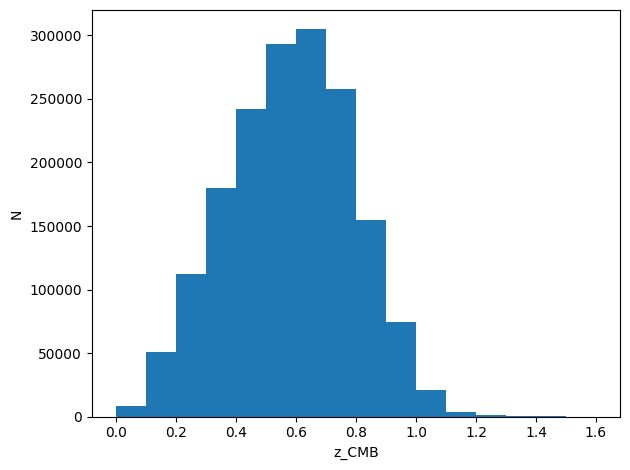

In [7]:
# Make a histogram of redshifts
fig, axes = pyplot.subplots( 1, 1, tight_layout=True )
axes.hist( snia_truth['ZCMB'], bins=numpy.arange( 0, 1.7, 0.1 ) )
axes.set_xlabel( r"z_CMB" )
axes.set_ylabel( r"N" )
# axes.set_yscale('log')

_;  # (Just to suppress gratuitous output.)

In [8]:
# Let's pick a random SN betwen z=0.1 and 0.2 to plot
zp1t2 = snia_truth[ ( snia_truth['ZCMB'] >= 0.1 ) & ( snia_truth['ZCMB'] < 0.2 ) ].reset_index()

# NOTE : have to be careful with Pandas, it sometimes does things you don't want it
# to do.  For instance,
#   snid = zp1t2.iloc[ rng.integers( 0, len(zp1t2) ) ]['SNID']
# should, return the same as the line below, or so you would think.
# But, if you use iloc, pandas seems to convert all numeric types
# to float64!  This is bad, because SNID is a 64-bit integer, and
# float64 only has 53 bits of precision in the mantissa. As such, you
# could very easily end up losing the actual value of the integer as it 
# gets rounded off, if it's big enough.  Always look at Pandas
# data types and be suspicious of what it's doing.
snid = zp1t2['SNID'][ rng.integers( 0, len(zp1t2) ) ]
print( f"Randomly chose {snid}, (type: {type(snid)})" )



Randomly chose 46880518, (type: <class 'numpy.int64'>)


[2024-10-23 11:01:50 - INFO] - Reading lightcurve from /data/raknop/ELASTICC2/ELASTICC2_FINAL_SNIa-SALT3/ELASTICC2_FINAL_NONIaMODEL0-0036_PHOT.FITS.gz


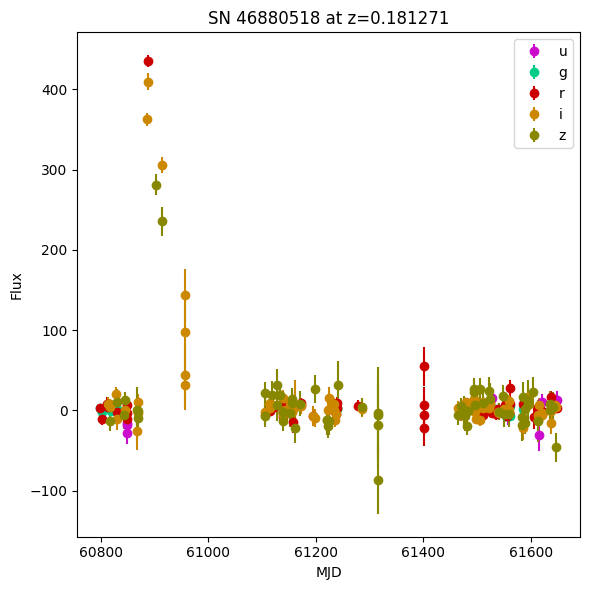

In [9]:
#...and plot it

ltcv = esr.get_ltcv( 'SNIa-SALT3', snid, return_format='pandas' )
plot_ltcv( ltcv )

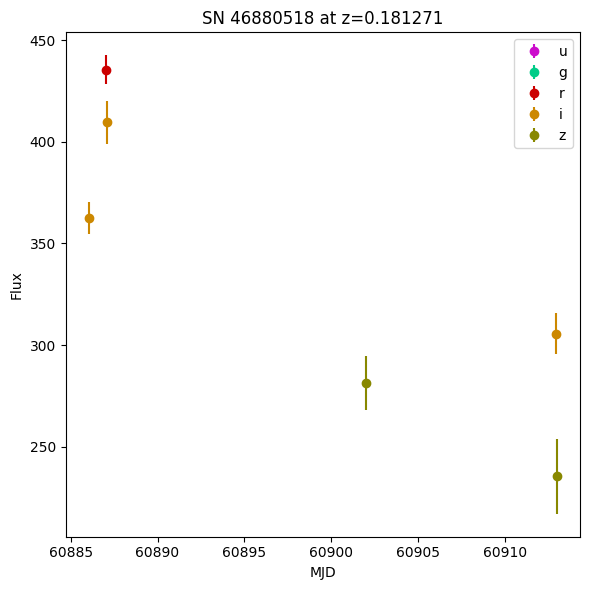

In [10]:
# That's too much forced photometry.  We could just manually crop down the
# limits of the x axis, but for demo purposes, let's select out just the
# points that counted as "detected":

detected_ltcv = ltcv[ ( ltcv['PHOTFLAG'] & esr.photflag_detect ) !=0 ]
plot_ltcv( detected_ltcv )

#...which should make you feel a little bit queasy about the WFD cadence...

In [11]:
# Suppose I wanted to find a supernova with "lots" of
# detections.  For this, we need to read all the lightcurves.
# Remember there are 1.7 million SNe Ia.  Reading all of those
# lightcurves from the gzipped PHOT files will take a long time
# (minutes and minutes).
#
# However, we can get just a subset of the lightcurves.  The
# PHOT files are divided into 40 separate files.  We can get
# all of the lightcurves from just one of them, and that won't
# be too many; reading one PHOT file will just take 10-20
# of seconds (depending on filesystem performance).
#
# elasticc2_snana_reader.get_all_ltcvs() will normally take
# the time necessary to read all of the phot files, but
# you can give it the parameter file_num=<num>, where <num>
# is between 1 and 40, to get a subset of the files.

_logger.info( "Getting SNe Ia lightcurves from file 1..." )
sneIa_ltcvs = esr.get_all_ltcvs( 'SNIa-SALT3', file_num=1, return_format='pandas' )
_logger.info( "...done" )


[2024-10-23 11:01:54 - INFO] - Getting SNe Ia lightcurves from file 1...
[2024-10-23 11:01:54 - INFO] - Reading /data/raknop/ELASTICC2/ELASTICC2_FINAL_SNIa-SALT3/ELASTICC2_FINAL_NONIaMODEL0-0001_PHOT.FITS.gz...
[2024-10-23 11:02:06 - INFO] - ...assigning SNID
[2024-10-23 11:02:07 - DEBUG] - Concatenating 1 dataframes
[2024-10-23 11:02:07 - DEBUG] - Sorting
[2024-10-23 11:02:07 - DEBUG] - Returning
[2024-10-23 11:02:07 - INFO] - ...done


In [12]:
# Try to get a random object with z=[0.1,0.2) and "lots" detections.

# Play some pandas games.  We want the count of detections for each object, and then
# we want to join that to the truth table.  The result of that join will crop
# down the truth table to just the object that are in file 1 (because we're doing
# an inner join), and will add the column 'ndetect' with the number of
# detections.  We can then filter on that and the redshift range and pick 
# out a supernovae with lots of detections.

detcounts = ( sneIa_ltcvs[ ( sneIa_ltcvs['PHOTFLAG'] 
                           & esr.photflag_detect ) != 0 ]
              .groupby( 'SNID' ).agg('count')['MJD']
              .reset_index().rename( {'MJD': 'ndetect'}, axis=1 ) )
truth_file1_withcounts = snia_truth.join( detcounts.set_index("SNID"), on='SNID', how='inner' )
subset = truth_file1_withcounts[ ( truth_file1_withcounts['ZCMB'] >= 0.1 ) & 
                                 ( truth_file1_withcounts['ZCMB'] < 0.2 ) & 
                                 ( truth_file1_withcounts['ndetect'] > 30 ) ]
snid = subset['SNID'].values[ rng.integers( 0, len(subset) ) ]
print( f"Picked SN {snid} with {subset[ subset['SNID']==snid ]['ndetect'].values[0]} detections" )

Picked SN 145416146 with 59 detections


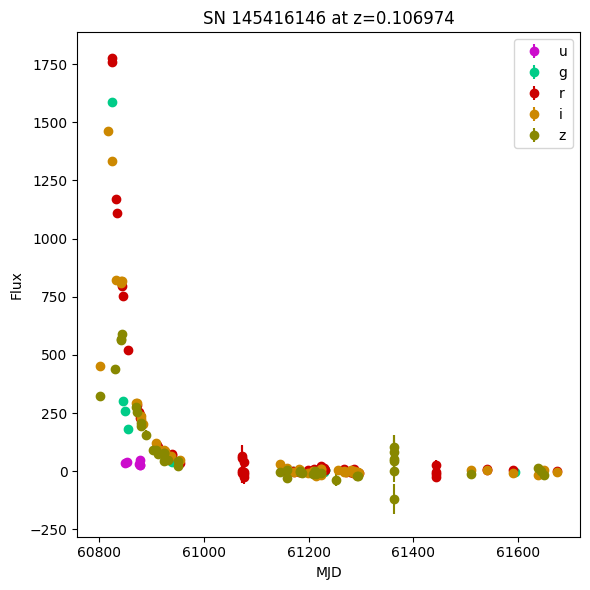

In [13]:
# We could extract the lightcurve with esr.get_ltcv() as we did before.  However,
# we already have it in memory in the sneIa_ltcvs variable we read earlier, so 
# instead play Pandas games to extract the lightcurve

ltcv = sneIa_ltcvs[ sneIa_ltcvs['SNID'] == snid ]
plot_ltcv( ltcv )


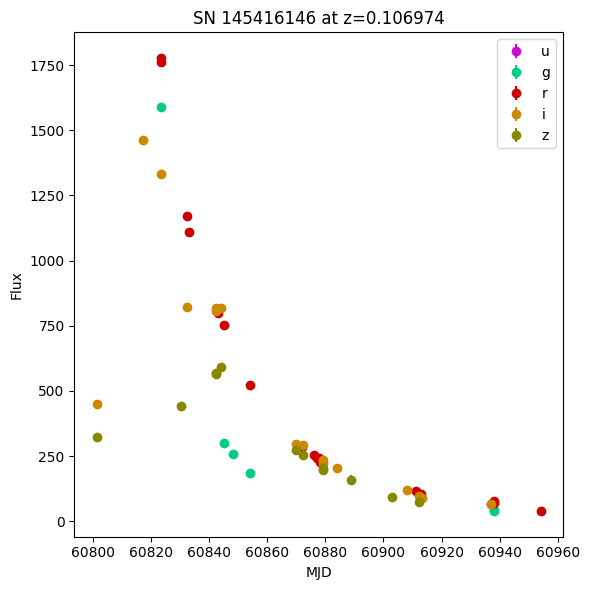

In [14]:
# Do the same thing of just plotting the detected points
detected_ltcv = ltcv[ ( ltcv['PHOTFLAG'] & esr.photflag_detect ) !=0 ]
plot_ltcv( detected_ltcv )


/tmp/ipykernel_1971/1460309316.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend()


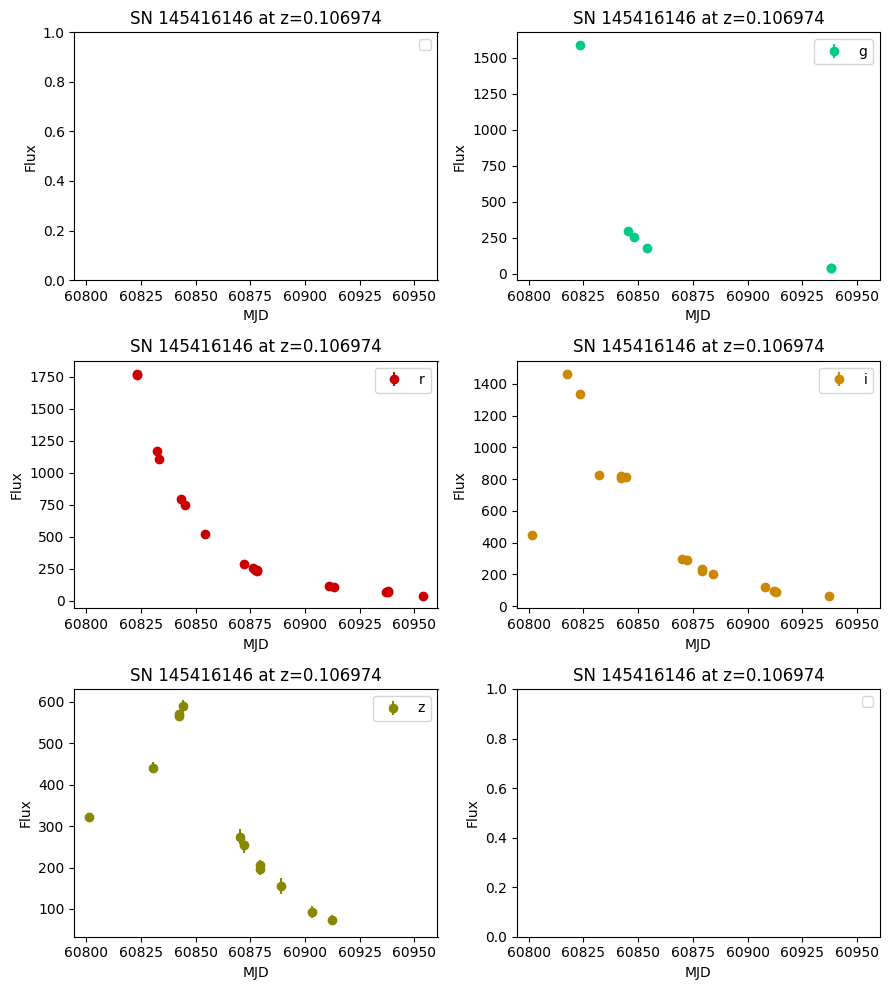

In [23]:
# This would probably look better with different bands in different plots....
plot_ltcv( detected_ltcv, figsize=(9, 10), multiplots=True )